## NOTE:
This one is plotting the results of "Analyze connectivity higher order sources". Run that notebook first.

In [1]:
import numpy
import pandas

import conntility

from scipy.spatial.distance import cdist
import tqdm

from matplotlib import pyplot as plt

## PART 1

In [2]:
fn_data = "/gpfs/bbp.cscs.ch/project/proj159/home/reimann/connectivity_higher_order_effect_24-11-11.h5"

df_human_pre = pandas.read_hdf(fn_data, key="human/pre")
df_human_post = pandas.read_hdf(fn_data, key="human/post")
df_rat_pre = pandas.read_hdf(fn_data, key="rat/pre")
df_rat_post = pandas.read_hdf(fn_data, key="rat/post")

Correlation coefficient between number of touches and number of touches with nearest neighbor

In [3]:
def corrcoef_from_contingency(series_in, cols_touches, col_values):
    x = series_in[cols_touches[0]].values
    y = series_in[cols_touches[1]].values
    z = series_in[col_values].values
    mn1 = (x * z).sum() / z.sum()
    mn2 = (y * z).sum() / z.sum()
    cov = ((x - mn1) * (y - mn2) * z).sum() / z.sum()

    v1 = (((x - mn1) ** 2) * z).sum() / z.sum()
    v2 = (((y - mn2) ** 2) * z).sum() / z.sum()

    return cov / numpy.sqrt(v1 * v2)

cc_human_pre = df_human_pre.groupby(["xz", "y"]).apply(corrcoef_from_contingency, ["touches_pair", "touches_nn_pre"], "count")
cc_human_post = df_human_post.groupby(["xz", "y"]).apply(corrcoef_from_contingency, ["touches_pair", "touches_nn_post"], "count")
cc_rat_pre = df_rat_pre.groupby(["xz", "y"]).apply(corrcoef_from_contingency, ["touches_pair", "touches_nn_pre"], "count")
cc_rat_post = df_rat_post.groupby(["xz", "y"]).apply(corrcoef_from_contingency, ["touches_pair", "touches_nn_post"], "count")

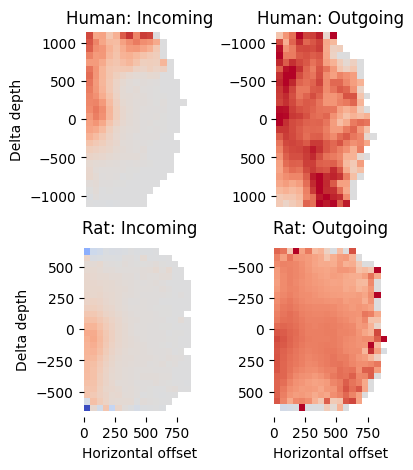

In [11]:
clim = [-0.5, 0.5]
cmap = "coolwarm"

def make_extent(df):
    delta_xz = df.columns[-1] - df.columns[-2]
    delta_y = df.index[-1] - df.index[-2]
    
    extent = [df.columns[0] - delta_xz/2, df.columns[-1] + delta_xz/2,
             df.index[-1] + delta_y/2, df.index[0] - delta_y/2]
    return extent

fig = plt.figure(figsize=(4.5, 5))

ax = fig.add_subplot(2, 2, 1)
img = cc_human_pre.sort_index().unstack("xz")
ax.imshow(img, extent=make_extent(img), clim=clim, cmap=cmap)
ax.set_ylim(sorted(ax.get_ylim()))
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_title("Human: Incoming")
ax.set_ylabel("Delta depth")

ax = fig.add_subplot(2, 2, 2)
img = cc_human_post.sort_index().unstack("xz")
ax.imshow(img, extent=make_extent(img), clim=clim, cmap=cmap)
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_title("Human: Outgoing")

ax = fig.add_subplot(2, 2, 3)
img = cc_rat_pre.sort_index().unstack("xz")
ax.imshow(img, extent=make_extent(img), clim=clim, cmap=cmap)
ax.set_ylim(sorted(ax.get_ylim()))
ax.set_frame_on(False)
ax.set_title("Rat: Incoming")
ax.set_ylabel("Delta depth")
ax.set_xlabel("Horizontal offset")

ax = fig.add_subplot(2, 2, 4)
img = cc_rat_post.sort_index().unstack("xz")
ax.imshow(img, extent=make_extent(img), clim=clim, cmap=cmap)
ax.set_frame_on(False)
ax.set_title("Rat: Outgoing")
ax.set_xlabel("Horizontal offset")

fig.savefig("cmp_touch_count_correlations_with_nn.pdf")

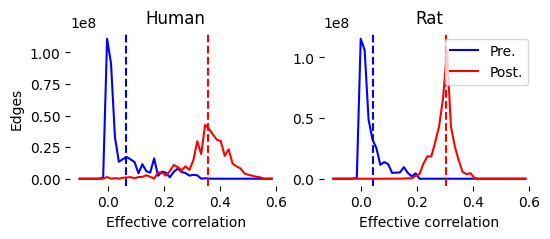

In [39]:
bins = numpy.linspace(-0.1, 0.6, 51)
fig = plt.figure(figsize=(6, 2))

ax = fig.add_subplot(1, 2, 1)
edges = df_human_pre.groupby(["xz", "y"])["count"].sum()
H = numpy.histogram(cc_human_pre.values, weights=edges.values, bins=bins)[0]
mn = edges.mul(cc_human_pre, fill_value=0).sum() / edges.sum()
ax.plot(bins[:-1], H, color="blue", label="Pre.")
ax.set_ylim(ax.get_ylim())
ax.plot([mn, mn], ax.get_ylim(), color="blue", ls="--")
ax.set_ylabel("Edges")
ax.set_xlabel("Effective correlation")
ax.set_title("Human")
ax.set_frame_on(False)

edges = df_human_post.groupby(["xz", "y"])["count"].sum()
H = numpy.histogram(cc_human_post.values, weights=edges.values, bins=bins)[0]
mn = edges.mul(cc_human_post, fill_value=0).sum() / edges.sum()
ax.plot(bins[:-1], H, color="red", label="Post.")
ax.set_ylim(ax.get_ylim())
ax.plot([mn, mn], ax.get_ylim(), color="red", ls="--")

ax = fig.add_subplot(1, 2, 2)
edges = df_rat_pre.groupby(["xz", "y"])["count"].sum()
H = numpy.histogram(cc_rat_pre.values, weights=edges.values, bins=bins)[0]
mn = edges.mul(cc_rat_pre, fill_value=0).sum() / edges.sum()
ax.plot(bins[:-1], H, color="blue", label="Pre.")
ax.set_ylim(ax.get_ylim())
ax.plot([mn, mn], ax.get_ylim(), color="blue", ls="--")

edges = df_rat_post.groupby(["xz", "y"])["count"].sum()
H = numpy.histogram(cc_rat_post.values, weights=edges.values, bins=bins)[0]
mn = edges.mul(cc_rat_post, fill_value=0).sum() / edges.sum()
ax.plot(bins[:-1], H, color="red", label="Post.")
ax.set_ylim(ax.get_ylim())
ax.plot([mn, mn], ax.get_ylim(), color="red", ls="--")
plt.legend()
ax.set_xlabel("Effective correlation")
ax.set_title("Rat")
ax.set_frame_on(False)

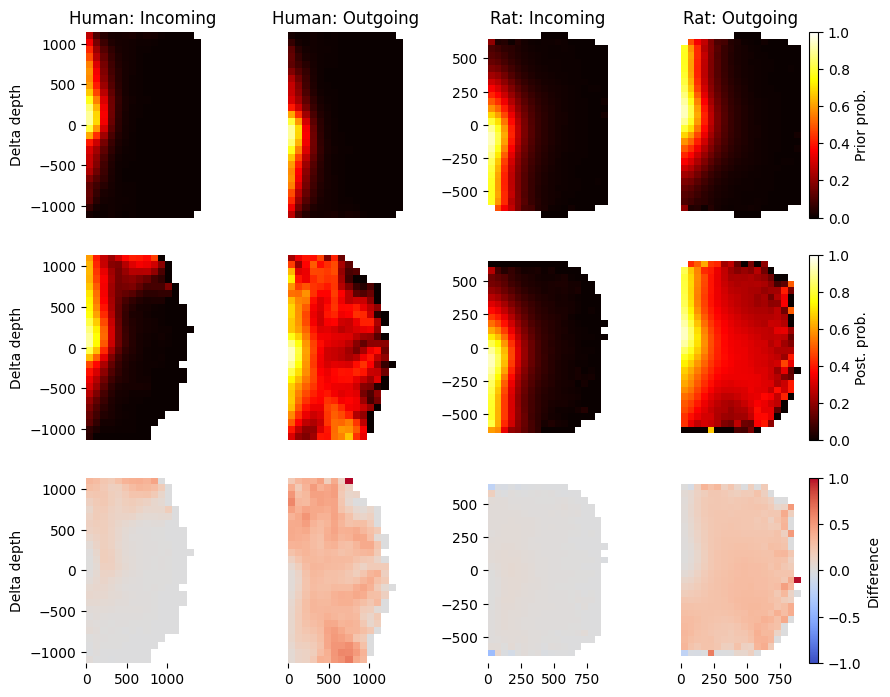

In [13]:
def p_prior_post_fun(df_in, thresh=1, col="touches_nn_post"):
    v = df_in["touches_pair"] >= thresh
    prior = df_in.loc[v]["count"].sum() / df_in["count"].sum()
    df_in = df_in.loc[v]
    v = df_in[col] >= thresh
    posterior = df_in.loc[v]["count"].sum() / df_in["count"].sum()
    return pandas.Series({
        "prior": prior,
        "posterior": posterior
    })


clim = [0.0, 1.0]
cmap = "hot"
thresh = 1

fig = plt.figure(figsize=(10, 8.2))
dfs = [df_human_pre, df_human_post, df_rat_pre, df_rat_post]
cols = ["touches_nn_pre", "touches_nn_post", "touches_nn_pre", "touches_nn_post"]
titles = ["Human: Incoming", "Human: Outgoing", "Rat: Incoming", "Rat: Outgoing"]
revert = [True, False, True, False]

for i in range(len(dfs)):
    dsrc = dfs[i]
    res = dsrc.groupby(["xz", "y"]).apply(p_prior_post_fun, thresh=thresh, col=cols[i])
    
    ax = fig.add_subplot(3, len(dfs), i + 1)
    img = res["prior"].sort_index().unstack("xz")
    pltimg = ax.imshow(img, extent=make_extent(img), clim=clim, cmap=cmap)
    ax.set_frame_on(False)
    #ax.set_title("Thresh: {0}".format(thresh))
    if i == 0:
        ax.set_ylabel("Delta depth")
    ax.set_title(titles[i])
    if i == (len(dfs) - 1):
        plt.colorbar(pltimg, label="Prior prob.")
    if revert[i]:
        ax.set_ylim(sorted(ax.get_ylim()))
    else:
        ax.set_yticks([])
    ax.set_xticks([])
    
    ax = fig.add_subplot(3, len(dfs), i + len(dfs) + 1)
    img = res["posterior"].sort_index().unstack("xz")
    pltimg = ax.imshow(img, extent=make_extent(img), clim=clim, cmap=cmap)
    ax.set_frame_on(False)
    if i == 0:
        ax.set_ylabel("Delta depth")
    if i == (len(dfs) - 1):
        plt.colorbar(pltimg, label="Post. prob.")
    if revert[i]:
        ax.set_ylim(sorted(ax.get_ylim()))
    else:
        ax.set_yticks([])
    ax.set_xticks([])
        
    ax = fig.add_subplot(3, len(dfs), i + len(dfs) + len(dfs) + 1)
    img = (res["posterior"] - res["prior"]) # / (res["prior"] + res["posterior"])
    img = img.sort_index().unstack("xz")
    pltimg = ax.imshow(img, extent=make_extent(img), clim=[-1.0, 1.0], cmap="coolwarm")
    ax.set_frame_on(False)
    if i == 0:
        ax.set_ylabel("Delta depth")
    if i == (len(dfs) - 1):
        plt.colorbar(pltimg, label="Difference")
    if revert[i]:
        ax.set_ylim(sorted(ax.get_ylim()))
    else:
        ax.set_yticks([])

fig.savefig("cmp_prior_posterior_probabilities.pdf")

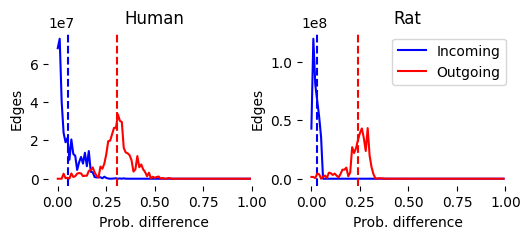

In [26]:
bins = numpy.linspace(0, 1.0, 101)

def make_hist(df_in, col):
    res = df_in.groupby(["xz", "y"]).apply(p_prior_post_fun, thresh=thresh, col=col)
    res = res["posterior"] - res["prior"]
    edges = df_in.groupby(["xz", "y"])["count"].sum()
    edges = edges.reindex(res.index, fill_value=0)

    H = numpy.histogram(res.values, weights=edges.values, bins=bins)[0]
    mn = edges.mul(res, fill_value=0).sum() / edges.sum()
    return H, mn

fig = plt.figure(figsize=(6, 2))

axes = [fig.add_subplot(1, 2, 1), fig.add_subplot(1, 2, 2)]
axes = [axes[0], axes[0], axes[1], axes[1]]
ttls = ["Human", "Human", "Rat", "Rat"]
lbls = [None, None, "Incoming", "Outgoing"]

for df_in, col, ax, c, ttl, lbl in zip(dfs, cols, axes, ["blue", "red", "blue", "red"], ttls, lbls):
    H, mn = make_hist(df_in, col)
    ax.plot(bins[:-1], H, color=c, label=lbl)
    ax.set_ylim(ax.get_ylim())
    ax.plot([mn, mn], ax.get_ylim(), color=c, ls="--")
    ax.set_ylabel("Edges")
    ax.set_xlabel("Prob. difference")
    ax.set_frame_on(False)
    ax.set_title(ttl)
plt.legend()

fig.savefig("cmp_effective_prob_difference.pdf")


## PART 2

In [66]:
fn_data = "/gpfs/bbp.cscs.ch/project/proj159/home/reimann/connectivity_higher_order_interactions_24-11-11.h5"

loaded = "human"
thresh = 1
CC_pre = pandas.read_hdf(fn_data, key="{0}/{1}/pre".format(loaded, thresh))
CC_post = pandas.read_hdf(fn_data, key="{0}/{1}/post".format(loaded, thresh))

In [67]:
locations = CC_pre.index.to_frame().reset_index(drop=True).drop_duplicates()

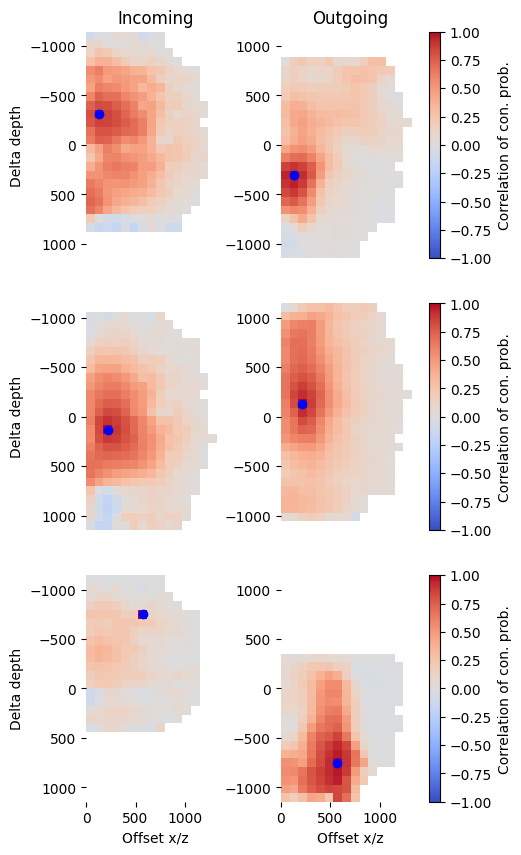

In [68]:
fig = plt.figure(figsize=(5, 10))
clim = [-1.0, 1.0]
location_ids = [35, 66, 160]
cmap="coolwarm"

pltid = 1
for _i, _loc in enumerate(location_ids): 
    ex_location = locations.iloc[_loc]
    ax = fig.add_subplot(3, 2, pltid + 1)
    img = CC_pre[tuple(ex_location.values)].unstack("xz")
    pltimg = ax.imshow(img, extent=make_extent(img), clim=clim, cmap=cmap)
    plt.plot(ex_location["xz"], ex_location["y"], marker='o', color="blue")
    plt.colorbar(pltimg, label="Correlation of con. prob.")
    if pltid > 4:
        ax.set_xlabel("Offset x/z")
    if pltid < 3:
        ax.set_title("Outgoing")
    if _i < (len(location_ids) - 1):
        ax.set_xticks([])
    ax.set_frame_on(False)
    ax.set_ylim(sorted(ax.get_ylim()))

    ax = fig.add_subplot(3, 2, pltid)
    img = CC_post[tuple(ex_location.values)].unstack("xz")
    pltimg = ax.imshow(img, extent=make_extent(img), clim=clim, cmap=cmap)
    plt.plot(ex_location["xz"], ex_location["y"], marker='o', color="blue")
    ax.set_ylabel("Delta depth")
    if pltid > 4:
        ax.set_xlabel("Offset x/z")
    if pltid < 3:
        ax.set_title("Incoming")
    if _i < (len(location_ids) - 1):
        ax.set_xticks([])
    ax.set_frame_on(False)
    pltid +=2

fig.savefig("spatial_bins_correlations_x_{0}.pdf".format(loaded))

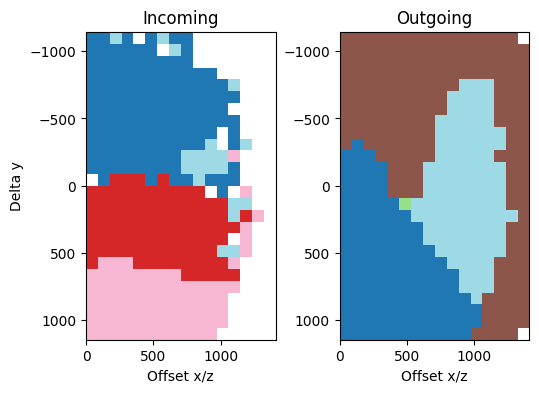

In [69]:
from sknetwork.clustering import Louvain, get_modularity
sz_thresh = 15
res_pre = 1.1
res_post = 1.1

def cluster_and_show(ax, data, res):
    L = Louvain(res).fit_predict(data).astype(float)
    Lcounts = pandas.Series(L).value_counts()
    toosmall = Lcounts.index[Lcounts.values < sz_thresh]
    L[numpy.isin(L, toosmall)] = numpy.NaN
    img = pandas.Series(L, index=CC_pre.index).unstack("xz")
    ax.imshow(img, cmap="tab20", extent=make_extent(img), interpolation="nearest")
    return L
    
fig = plt.figure(figsize=(6, 4))

ax = fig.add_subplot(1, 2, 2)
L_pre = cluster_and_show(ax, CC_pre.fillna(0).values - CC_pre.min().min(), res_pre)
L_pre = cluster_and_show(ax, numpy.maximum(CC_pre.fillna(0).values, 0), res_pre)
ax.set_xlabel("Offset x/z")
ax.set_ylabel("Delta y")
ax.set_title("Outgoing")

ax = fig.add_subplot(1, 2, 1)
L_post = cluster_and_show(ax, numpy.maximum(CC_post.fillna(0).values, 0), res_post)
ax.set_xlabel("Offset x/z")
ax.set_title("Incoming")
ax.set_ylabel("Delta y")

fig.savefig("spatial_bins_clustering_{0}.pdf".format(loaded))

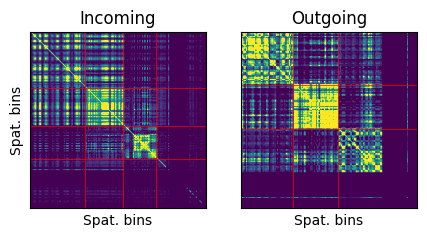

In [70]:
fig = plt.figure(figsize=(5, 2.5))

ax = fig.add_subplot(1, 2, 1)
_idx = numpy.argsort(L_post)

ax.imshow(CC_post.fillna(0).values[numpy.ix_(_idx, _idx)], clim=[0, 0.5])
borders = numpy.nonzero(numpy.diff(L_post[_idx]) > 0)[0]
ax.set_xlim(ax.get_xlim()); ax.set_ylim(ax.get_ylim())
for b in borders:
    ax.plot(ax.get_xlim(), [b, b], color="red", lw=0.5)
    ax.plot([b, b], ax.get_ylim(), color="red", lw=0.5)
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlabel("Spat. bins")
ax.set_ylabel("Spat. bins")
ax.set_title("Incoming")

ax = fig.add_subplot(1, 2, 2)
_idx = numpy.argsort(L_pre)

ax.imshow(CC_pre.fillna(0).values[numpy.ix_(_idx, _idx)], clim=[0, 0.5])
borders = numpy.nonzero(numpy.diff(L_pre[_idx]) > 0)[0]
ax.set_xlim(ax.get_xlim()); ax.set_ylim(ax.get_ylim())
for b in borders:
    ax.plot(ax.get_xlim(), [b, b], color="red", lw=0.5)
    ax.plot([b, b], ax.get_ylim(), color="red", lw=0.5)
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlabel("Spat. bins")
ax.set_title("Outgoing")

fig.savefig("spatial_bins_clustered_matrices_{0}.pdf".format(loaded))

## Part 2B

I kind of abandonded this idea

In [52]:
fn_data = "/gpfs/bbp.cscs.ch/project/proj159/home/reimann/connectivity_higher_order_interactions_24-11-11.h5"

thresh = 1
CC_pre_rat = pandas.read_hdf(fn_data, key="{0}/{1}/pre".format("rat", thresh))
CC_post_rat = pandas.read_hdf(fn_data, key="{0}/{1}/post".format("rat", thresh))
CC_pre_human = pandas.read_hdf(fn_data, key="{0}/{1}/pre".format("human", thresh))
CC_post_human = pandas.read_hdf(fn_data, key="{0}/{1}/post".format("human", thresh))

edges_pre_rat = pandas.read_hdf(fn_data, key="{0}/{1}/pre_N".format("rat", thresh))
edges_post_rat = pandas.read_hdf(fn_data, key="{0}/{1}/post_N".format("rat", thresh))
edges_pre_human = pandas.read_hdf(fn_data, key="{0}/{1}/pre_N".format("human", thresh))
edges_post_human = pandas.read_hdf(fn_data, key="{0}/{1}/post_N".format("human", thresh))

In [53]:
def only_beyond_distance(edges, cutoff=200):
    E = edges.index.to_frame().reset_index(drop=True).values
    edges.loc[(E[:, 0] < cutoff) | (numpy.abs(E[:, 1]) < cutoff)] = 0

for edges in [edges_pre_rat, edges_post_rat, edges_pre_human, edges_post_human]:
    print(edges.sum())
    only_beyond_distance(edges)
    print(edges.sum())

33260.9269668786
14862.519695156985
33260.9269668786
14862.519695156985
39323.90783545232
29283.154538136667
39323.90783545232
29283.154538136667


In [54]:
edges_pre_rat = edges_pre_rat.reset_index().set_index(["xz", "y"])
edges_post_rat = edges_post_rat.reset_index().set_index(["xz", "y"])
edges_pre_human = edges_pre_human.reset_index().set_index(["xz", "y"])
edges_post_human = edges_post_human.reset_index().set_index(["xz", "y"])

In [55]:
to_pairs = lambda _df: pandas.DataFrame(numpy.sqrt(numpy.dot(_df.values, _df.values.reshape((1, -1)))),
                                        index=_df.index, columns=_df.index)
pair_pre_rat = to_pairs(edges_pre_rat)
pair_post_rat = to_pairs(edges_post_rat)
pair_pre_human = to_pairs(edges_pre_human)
pair_post_human = to_pairs(edges_post_human)

/nvme/reimann/2636495/ipykernel_124075/1058698811.py:21: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(ax.get_ylim())


[Text(0.5, 0, 'Human'), Text(2.5, 0, 'Rat')]

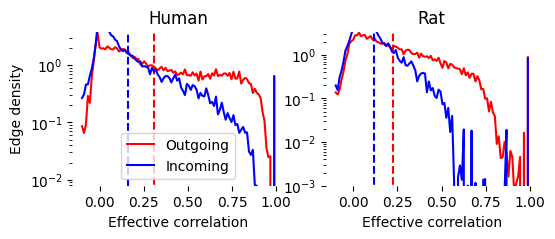

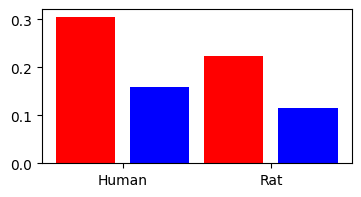

In [56]:
cc_bins = numpy.linspace(-0.1, 1.0, 101)
fig = plt.figure(figsize=(6, 2))


ax = fig.add_subplot(1, 2, 1)
H = numpy.histogram(CC_pre_human.values.flatten(),
                    weights=pair_pre_human.values.flatten(), bins=cc_bins, density=True)[0]
mn = (cc_bins[:-1] * H).sum() / H.sum()
ax.plot(cc_bins[:-1], H, color="red", label="Outgoing")
ax.set_ylim(ax.get_ylim())
ax.plot([mn, mn], ax.get_ylim(), color="red", ls="--")
ax.set_ylabel("Edge density")
ax.set_xlabel("Effective correlation")
ax.set_title("Human")
ax.set_yscale("log")
ax.set_frame_on(False)

H = numpy.histogram(CC_post_human.values.flatten(),
                    weights=pair_post_human.values.flatten(), bins=cc_bins, density=True)[0]
ax.plot(cc_bins[:-1], H, color="blue", label="Incoming")
ax.set_ylim(ax.get_ylim())
plt.legend()

fig_bar = plt.figure(figsize=(4, 2))
ax_bar = fig_bar.gca()
ax_bar.bar([0], [mn], fc="red")
mn = (cc_bins[:-1] * H).sum() / H.sum()
ax.plot([mn, mn], ax.get_ylim(), color="blue", ls="--")
ax_bar.bar([1], [mn], fc="blue")

ax = fig.add_subplot(1, 2, 2)
H = numpy.histogram(CC_pre_rat.values.flatten(),
                    weights=pair_pre_rat.values.flatten(), bins=cc_bins, density=True)[0]
mn = (cc_bins[:-1] * H).sum() / H.sum()
ax.plot(cc_bins[:-1], H, color="red", label="Outgoing")
ax.set_ylim(ax.get_ylim())
ax.plot([mn, mn], ax.get_ylim(), color="red", ls="--")
ax_bar.bar([2], [mn], fc="red")

H = numpy.histogram(CC_post_rat.values.flatten(),
                    weights=pair_post_rat.values.flatten(), bins=cc_bins, density=True)[0]
mn = (cc_bins[:-1] * H).sum() / H.sum()
ax.plot(cc_bins[:-1], H, color="blue", label="Incoming")
ax.set_ylim(ax.get_ylim())
ax.plot([mn, mn], ax.get_ylim(), color="blue", ls="--")
ax.set_xlabel("Effective correlation")
ax.set_title("Rat")
ax.set_ylim([1E-3, numpy.max(ax.get_ylim())])
ax.set_yscale("log")
ax.set_frame_on(False)
ax_bar.bar([3], [mn], fc="blue")

ax_bar.set_xticks([0.5, 2.5])
ax_bar.set_xticklabels(["Human", "Rat"])